# Movie Poster Genre Classification

This notebook uses TensorFlow's Keras to train a model to classify the genre of a movie based on its poster. Training data is obtained from TMDB.


## Get Training Data

 Install wrapper for [TMDB API](https://developers.themoviedb.org/3/getting-started/introduction) and other dependancies.

In [4]:
%pip install tmdbsimple
%pip install Pillow

Import dependancies and define helper functions.

In [0]:
import tmdbsimple as tmdb
tmdb.API_KEY = '0be0bfcb16519f6f20e8a5cf6a5605a8'

In [0]:
from PIL import Image
f'Pillow Version: {PIL.__version__}'
import requests
from io import BytesIO
import numpy as np
from matplotlib import pyplot as plt


In [0]:
def get_image(path):
  url = f'https://image.tmdb.org/t/p/w92{path}'
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  data = np.asarray(image)
  return data

In [0]:
def show_image(data):
  plt.imshow(data, interpolation='nearest')
  plt.show()

Request a list of movies from TMDB API.

In [123]:
raw_movies = [movie for i in range(1, 20) for movie in tmdb.Movies().popular(page=i)['results']]
len(movies)

380

Test out downloading, converting to array and printing a poster image for a movie in the list.

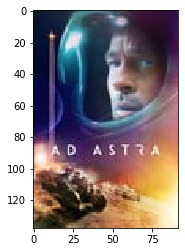

In [124]:
data = get_image(raw_movies[0]['poster_path'])
show_image(data)

Parse out an list of images and list of corresponding genres.

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

genres = tmdb.Genres().movie_list()['genres']
genre_names_by_id = {genre['id']: genre['name'] for genre in genres}


In [248]:
movies_with_genres = [movie for movie in raw_movies if len(movie['genre_ids']) > 0] # Filter for movies that have genres
movies_with_genres_dictionary = [{'genres': [genre_names_by_id[genre] for genre in movie['genre_ids']], 'image': get_image(movie['poster_path'])} for movie in movies_with_genres] # Put movie genre ids and images in dictionary
movies_with_genres_dictionary = [movie for movie in movies_with_genres_dictionary if movie['image'].shape == (138, 92, 3)] # Filter for movies with same size poster
movie_images_list = [movie['image'] for movie in movies_with_genres_dictionary] 
movie_genres_list = [movie['genres'] for movie in movies_with_genres_dictionary]
len(movies_with_genres_dictionary)

366

Fix format of training and test data for the model.

In [0]:
movie_genres_onehot = mlb.fit_transform(movie_genres_list)

In [0]:
movie_genres_arr = np.asarray(movie_genres_onehot)
movie_images_arr = np.asarray(movie_images_list)

## Observe Training Data

Not all movies are the same length, but thats fixed now.

In [73]:
[image.shape for image in movie_images_arr if image.shape[0] != 138]

[(132, 92, 3), (131, 92, 3), (133, 92, 3)]

## Generate Model

In [55]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [57]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.1.0


In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(138, 92, 3)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(18, activation='sigmoid')
])

In [0]:
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Train Model

In [0]:
training_images_arr = movie_images_arr[::2]
training_genres_arr = movie_genres_arr[::2]

test_images_arr = movie_images_arr[1::2]
test_genres_arr = movie_genres_arr[1::2]

In [202]:
training_genres_arr.shape

(183, 18)

In [289]:
model.fit(training_images_arr, training_genres_arr, epochs=5)

Train on 183 samples
Epoch 1/5
183/183 [==============================] - 0s 1ms/sample - loss: 68.3894 - accuracy: 0.8488
Epoch 2/5
183/183 [==============================] - 0s 1ms/sample - loss: 46.8009 - accuracy: 0.8652
Epoch 3/5
183/183 [==============================] - 0s 1ms/sample - loss: 32.4635 - accuracy: 0.8767
Epoch 4/5
183/183 [==============================] - 0s 1ms/sample - loss: 24.6123 - accuracy: 0.8770
Epoch 5/5
183/183 [==============================] - 0s 1ms/sample - loss: 18.8466 - accuracy: 0.9089


In [290]:
test_loss, test_acc = model.evaluate(test_images_arr,  test_genres_arr, verbose=2)
print('\nTest accuracy:', test_acc)

183/183 - 0s - loss: 53.6524 - accuracy: 0.7933

Test accuracy: 0.7932604


# Visualizing

In [0]:
predictions = model.predict(test_images_arr)
predictions_rounded = np.rint(predictions)
filtered_prediction_scores = [[score for score_i, score in enumerate(scores) if predictions_rounded[i][score_i] == 1] for i, scores in enumerate(predictions) ]

In [292]:
predictions_by_genre = mlb.inverse_transform(predictions_rounded)
predictions_with_score = [[{genre: filtered_prediction_scores[genres_idx][genre_idx]} for genre_idx, genre in enumerate(genres)] for genres_idx, genres in enumerate(predictions_by_genre)]
predictions_with_score[:5]

[[{'Drama': 1.0}],
 [{'Comedy': 1.0}],
 [{'Action': 1.0}, {'Fantasy': 0.9999939}],
 [{'Action': 1.0}, {'Comedy': 1.0}, {'Fantasy': 1.0}],
 [{'Action': 0.9999982}]]

In [293]:
test_genres_actual = mlb.inverse_transform(test_genres_arr)
movie_genre_prediction_compare_object = [{'image': test_images_arr[i], 'predictions': predictions_by_genre[i], 'actual': test_genres_actual[i]} for i in range(len(test_images_arr))]
movie_genre_prediction_compare_object[8]

{'actual': ('Adventure', 'Animation', 'Comedy', 'Family'),
 'image': array([[[188, 208, 232],
         [185, 207, 231],
         [180, 206, 229],
         ...,
         [138, 183, 222],
         [132, 184, 224],
         [130, 183, 225]],
 
        [[195, 211, 236],
         [192, 210, 234],
         [188, 208, 232],
         ...,
         [153, 189, 225],
         [147, 189, 227],
         [145, 189, 228]],
 
        [[199, 211, 235],
         [198, 210, 232],
         [198, 209, 229],
         ...,
         [166, 186, 219],
         [162, 188, 223],
         [159, 189, 225]],
 
        ...,
 
        [[113,  85,  61],
         [111,  83,  61],
         [106,  78,  56],
         ...,
         [ 95,  72,  58],
         [ 88,  65,  51],
         [ 87,  64,  50]],
 
        [[118,  90,  66],
         [114,  86,  64],
         [117,  89,  67],
         ...,
         [ 94,  71,  57],
         [102,  79,  65],
         [ 86,  63,  49]],
 
        [[118,  90,  66],
         [114,  86,  64],


In [0]:
def display_predictions(prediction_compare_object, n):
  for i in range(n):
    movie = prediction_compare_object[i]
    show_image(movie['image'])
    print(f'Actual Genres: {movie["actual"]}')
    print(f'Predicted Genres: {movie["predictions"]}')
    

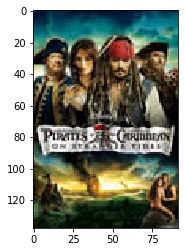

Actual Genres: ('Action', 'Adventure', 'Fantasy')
Predicted Genres: ('Action', 'Fantasy')


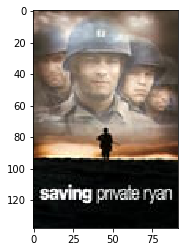

Actual Genres: ('Drama', 'History', 'War')
Predicted Genres: ()


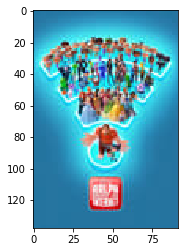

Actual Genres: ('Adventure', 'Animation', 'Comedy', 'Family')
Predicted Genres: ('Comedy', 'Drama')


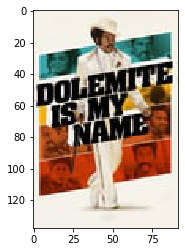

Actual Genres: ('Comedy', 'Drama', 'History')
Predicted Genres: ('Action', 'Drama', 'Thriller')


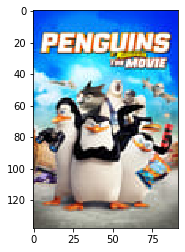

Actual Genres: ('Adventure', 'Animation', 'Comedy', 'Family')
Predicted Genres: ('Thriller',)


In [294]:
display_predictions(movie_genre_prediction_compare_object[100:110], 5)

In [0]:
def intersection(actual, predicted):
  same = [genre for genre in predicted if genre in actual]
  return len(same)

In [295]:
correct_genres = [intersection(movie['actual'], movie['predictions']) for movie in movie_genre_prediction_compare_object]
correct_genres[60:70]

[0, 1, 0, 0, 1, 0, 0, 0, 0, 1]

In [296]:
np.average(correct_genres)

0.7595628415300546

In [297]:
np.std(correct_genres)

0.7220976010931583

In [298]:
np.max(correct_genres)

3